In [1]:
import numpy as np
from pint import UnitRegistry
import math
ureg = UnitRegistry()
np.set_printoptions(precision=4)
import sys
sys.path.append('/Users/Lampe/PyScripts/surgeAnalysis')
import SurgeFunc as sf

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

### Problem Data

In [12]:
# numerical parameters
nel = int(1000) # number of elements
tf = 20.0 # total calculation tim (sec)

#problem Data
Tc = 10. # time for total valve closure (sec)
degTheta = 90.0 # 90->vertical well, 0->horizontal well
p0 = 20#3.9224 # reservoir pressure (MPa)
q0 = 3.0*3600 # SS flow rate (m3/hr)

mu = np.array([1.60 * 10**-3,1.60 * 10**-3]) # Dynamic viscosity (Pa-s, N-s/m2)
sg = np.array([1.0, 1.0]) # specific gravity
rough = np.array([0.9, 0.9]) # roughness (mm)
d = np.array([273.1, 273.1]) # mm
a = np.array([1000., 1000.]) # speed of sound in fluid (m/s)
L = np.array([50., 50.]) # length of each conduit reach (m)

### Calculated Constants

In [13]:
nnode = nel + 1 # number of nodes
x = np.linspace(0., sum(L), nnode) # spatial discretization
nrlp = np.sum(x[:]>=L[-1])# number of reachs in last segment

dx = sum(L)/nel
s = dx/max(a)#dx / max(a); # time step size (s)
t = np.linspace(0, tf, tf/s + 1) # time discretization

### Courant Evaluation

In [14]:
Courant = max(a)*s/dx; Courant
print(Courant)
print(s)
print(dx)

1.0
0.1
0.1


### Fluid / Conduit specific values

In [15]:
A = np.pi * (d / 1000.)**2 / 4. # area of flow (m2)
ani = L / (s*a)
g = 9.806 # m/s2
rho = sg * 1000 # kg/m3

f = np.zeros(len(d))
ca = np.zeros(len(d))
cf = np.zeros(len(d))
cb = np.zeros(len(d))
for i in xrange(len(d)):
    f[i] = sf.SS_DeltaH(q0, mu[i], sg[i], d[i], rough[i], x, degTheta, units=1).Calc().f # friction factor 
    ca[i] = g * A[i] / a[i] # m2/sec
    cf[i] = s * f[i]/(2*(d[i]/1000.)*A[i]) #assumed constant (sec/m3)
    cb[i] = s * g * A[i] * np.sin(degTheta*np.pi / 180.0)

In [16]:
print(f)

[ 0.0269  0.0269]


### Create Empty Arrays

In [17]:
# rows-> spatial disc; column -> temporal disc
h = np.zeros((len(x), len(t))) # head (m)
q = np.zeros((len(x), len(t))) # flow rate (m3/hr)
p = np.zeros((len(x), len(t))) # pressure (MPa)
qp = np.zeros((len(x))) # future flow rate along the positive characteristic (m3/hr)
hp = np.zeros((len(x))) # future head along the positive characteristic (m3/hr)

### Steady State Calc

In [18]:
for i in xrange(len(x)):
    if x[i] < x[nrlp]:
        idx = 0
    else:
        idx = 1
    q[i,0] = q0 / 3600. # steady flow (m3/sec)
    h[i,0] = (p0*10**6)/(rho[idx]*g) + sf.SS_DeltaH(q0, mu[idx], sg[idx], d[idx], rough[idx],
                                                  x[i], degTheta, units=1).Calc().dh # head (m)

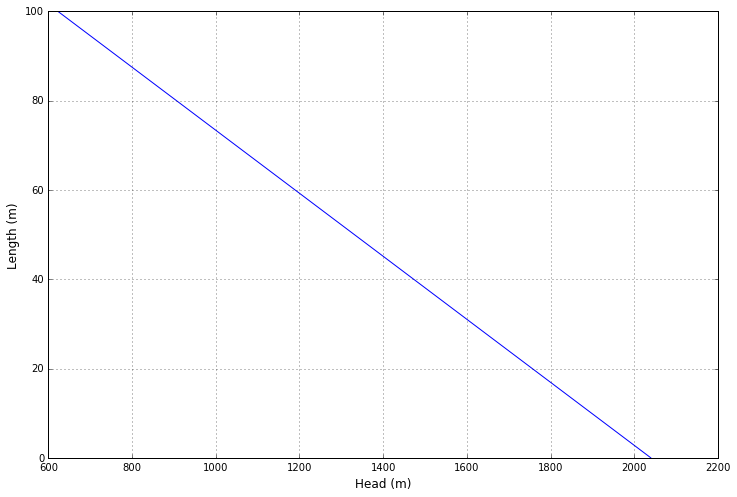

In [36]:
fig_ICs, ax = plt.subplots(figsize = (12,8))
   
# ax.plot(h[:,start:stop:inc],x)
ax.plot(h[:,0],x, label='Initial Conditions')
# ax.legend(lbl, frameon=1, framealpha = 1, loc=2)

# ax.invert_yaxis()
# ax.invert_xaxis()
ax.set_xlabel('Head (m)', fontsize = 12)
ax.set_ylabel('Length (m)', fontsize = 12)
# ax.set_title(''r'Time Integration Convergence Analysis, $\alpha = 0.5 \Rightarrow$ Implicit' , fontsize = 16)
ax.grid(b = True, which = 'major')
ax.grid(b = True, which = 'major')
# ax.set_ylim(0, 2)

fig_name = 'InitialConditions.pdf'
path = '/Users/Lampe/Documents/PB/SurgeAnalysis/Results/'
fig_ICs.savefig(path + fig_name)

### Main Program

In [21]:
# initial values at upstream reservoir
# cn = q[1,0] - ca[0]*h[1,0] - cf[0] * q[1,0] * np.abs(q[1,0]) # negative characteristic (m3)
cn = q[1,0] - ca[0]*h[1,0] - cb[0] - cf[0] * q[1,0] * np.abs(q[1,0]) # negative characteristic (m3)
qp[0] = cn + ca[0]*h[0,0]

# interior nodes
i_arr = np.arange(1,len(x)-1,1) # spatial index
j_arr = np.arange(0,len(t)-1,1) # spatial index
for j in j_arr:
    for i in i_arr:
        if x[i] < x[nrlp]:
            idx = 0
        else:
            idx = 1
        ip1 = i + 1
        im1 = i - 1
#         cn = q[ip1, j] - ca[idx]*h[ip1,j] - cf[idx]*q[ip1,j] - cf[idx]*q[ip1,j]*np.abs(q[ip1,j])
#         cp = q[im1, j] + ca[idx]*h[im1,j] - cf[idx]*q[im1,j] - cf[idx]*q[im1,j]*np.abs(q[im1,j])
        cn = q[ip1, j] - ca[idx]*h[ip1,j] - cb[idx] - cf[idx]*q[ip1,j]*np.abs(q[ip1,j])
        cp = q[im1, j] + ca[idx]*h[im1,j] - cb[idx] - cf[idx]*q[im1,j]*np.abs(q[im1,j])
        qp[i] = 0.5 * (cn + cp)
        hp[i] = (cp - qp[i])/ ca[idx]
        if i == 1: # calculations for upstream reservoir BCTs
            hp[0] = h[0,0] # Constant upstream reservoir head (m)
            qp[0] = cn + ca[idx]*hp[0]
        if i == len(x) - 2: # calculations for downstream valve BCTs
            tau = sf.valvePercOpen(t[j], Tc) # relative valve opening
            cv = (tau * q[-1,0])**2 / (ca[-1]*h[-1,0])
            qp[i+1] = 0.5 * (-cv + (cv**2 + 4 * cp * cv)**(0.5))
            hp[i+1] = (cp - qp[i])/ ca[-1]
    q[:,j+1] = qp
    h[:,j+1] = hp

In [22]:
print(x.shape)
print(h.shape)
max_value = max(h[-1,:])
max_index = np.argmax(h[-1,:])
print(max_value)
print(max_index*s)

(1001,)
(1001, 200001)
2005.760596
8.76


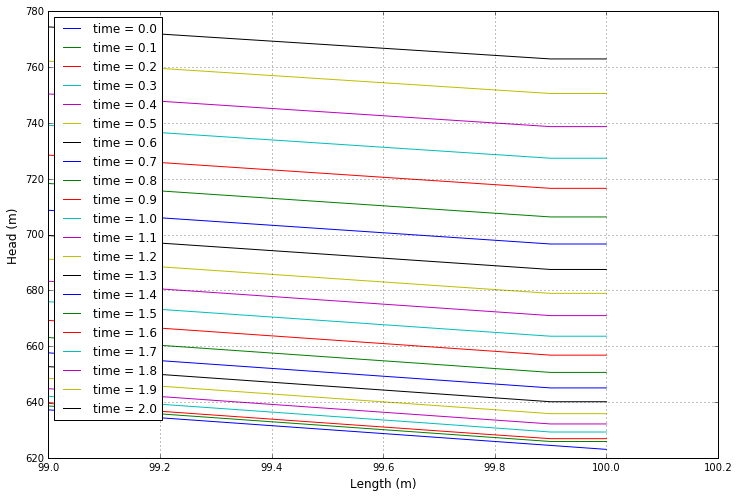

In [23]:
# figure h
fig_h, ax = plt.subplots(figsize = (12,8))

start= 0
stop = 20001
inc =  1000

lbl = [None]*len(t[start:stop:inc])
for i in xrange(len(lbl)):
    lbl[i] = 'time = '+ str(t[start:stop:inc][i])
    
# ax.plot(h[:,start:stop:inc],x)
ax.plot(x[990:],h[990:,start:stop:inc])
ax.legend(lbl, frameon=1, framealpha = 1, loc=2)

# ax.invert_yaxis()
ax.set_ylabel('Head (m)', fontsize = 12)
ax.set_xlabel('Length (m)', fontsize = 12)
# ax.set_title(''r'Time Integration Convergence Analysis, $\alpha = 0.5 \Rightarrow$ Implicit' , fontsize = 16)
ax.grid(b = True, which = 'major')
ax.grid(b = True, which = 'major')
# ax.set_ylim(0, 2)

# fig_name = '3b_1.pdf'
# path = '/Users/Lampe/Documents/UNM_Courses/ME-500/HW05/'
# fig_1DOF_4.savefig(path + fig_name)

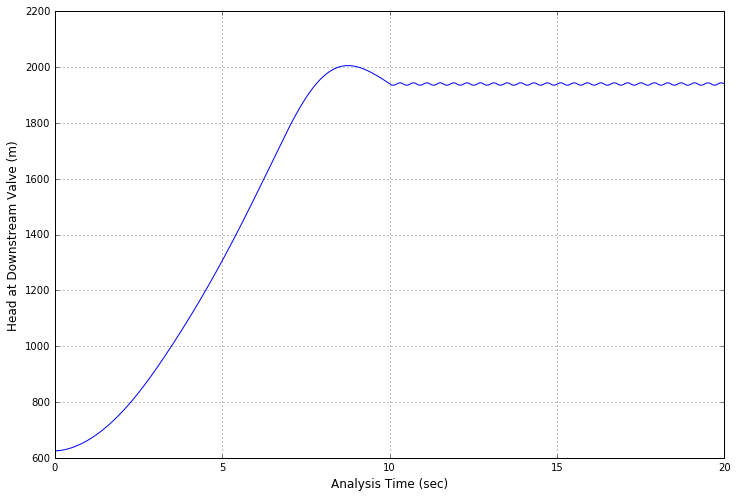

In [25]:
fig_HeadAtWH, ax = plt.subplots(figsize = (12,8))
   
# ax.plot(h[:,start:stop:inc],x)
ax.plot(t,h[-1,:])
# ax.legend(lbl, frameon=1, framealpha = 1, loc=2)

# ax.invert_yaxis()
ax.set_ylabel('Head at Downstream Valve (m)', fontsize = 12)
ax.set_xlabel('Analysis Time (sec)', fontsize = 12)
# ax.set_title(''r'Time Integration Convergence Analysis, $\alpha = 0.5 \Rightarrow$ Implicit' , fontsize = 16)
ax.grid(b = True, which = 'major')
ax.grid(b = True, which = 'major')
# ax.set_ylim(0, 2)

fig_name = 'HeadAtWH.pdf'
path = '/Users/Lampe/Documents/PB/SurgeAnalysis/Results/'
fig_HeadAtWH.savefig(path + fig_name)

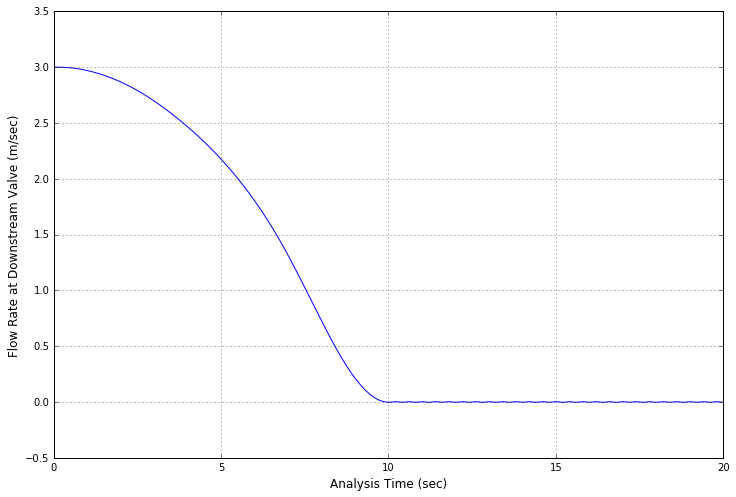

In [30]:
fig_QAtWH, ax = plt.subplots(figsize = (12,8))
   
# ax.plot(h[:,start:stop:inc],x)
ax.plot(t,q[-1,:])
# ax.legend(lbl, frameon=1, framealpha = 1, loc=2)

# ax.invert_yaxis()
ax.set_ylabel('Flow Rate at Downstream Valve (m/sec)', fontsize = 12)
ax.set_xlabel('Analysis Time (sec)', fontsize = 12)
# ax.set_title(''r'Time Integration Convergence Analysis, $\alpha = 0.5 \Rightarrow$ Implicit' , fontsize = 16)
ax.grid(b = True, which = 'major')
ax.grid(b = True, which = 'major')
# ax.set_ylim(0, 2)

# fig_name = 'FlowRateAtWH.pdf'
# path = '/Users/Lampe/Documents/PB/SurgeAnalysis/Results/'
# fig_QAtWH.savefig(path + fig_name)

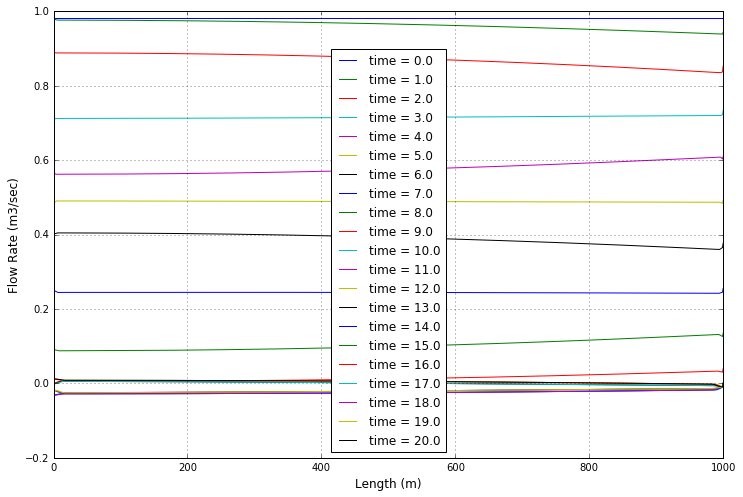

In [21]:
# figure h
fig_q, ax = plt.subplots(figsize = (12,8))

start= 0
stop = 20001
inc =  1000

lbl = [None]*len(t[start:stop:inc])
for i in xrange(len(lbl)):
    lbl[i] = 'time = '+ str(t[start:stop:inc][i])
    
# ax.plot(h[:,start:stop:inc],x)
ax.plot(x,q[:,start:stop:inc])
ax.legend(lbl, frameon=1, framealpha = 1, loc=0)

# ax.invert_yaxis()
ax.set_ylabel('Flow Rate (m3/sec)', fontsize = 12)
ax.set_xlabel('Length (m)', fontsize = 12)
# ax.set_title(''r'Time Integration Convergence Analysis, $\alpha = 0.5 \Rightarrow$ Implicit' , fontsize = 16)
ax.grid(b = True, which = 'major')
ax.grid(b = True, which = 'major')
# ax.set_ylim(0, 2)

# fig_name = '3b_1.pdf'
# path = '/Users/Lampe/Documents/UNM_Courses/ME-500/HW05/'
# fig_1DOF_4.savefig(path + fig_name)